# **EEEM068 PROJECT**
# **Melanoma Classification**



---

Group Members:
Taman Bachani |
Azizbek Fatkhullaev |
Efe Pekgoz |
Sara Aptha

In [1]:
#Command to check the GPU
!nvidia-smi

Sat May 11 12:19:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
#Mounting Drive to work collaboratively and for efficient data handling

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Loading the dataset into the runtime

In [3]:
#Dataset is unzipped from drive dolder into runtime

!unzip /content/drive/MyDrive/AML_Coursework/melanoma_dataset.zip -d /content/

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: /content/melanoma_cancer_dataset/train/benign/melanoma_643.jpg  
  inflating: /content/melanoma_cancer_dataset/train/benign/melanoma_644.jpg  
  inflating: /content/melanoma_cancer_dataset/train/benign/melanoma_645.jpg  
  inflating: /content/melanoma_cancer_dataset/train/benign/melanoma_646.jpg  
  inflating: /content/melanoma_cancer_dataset/train/benign/melanoma_647.jpg  
  inflating: /content/melanoma_cancer_dataset/train/benign/melanoma_648.jpg  
  inflating: /content/melanoma_cancer_dataset/train/benign/melanoma_649.jpg  
  inflating: /content/melanoma_cancer_dataset/train/benign/melanoma_65.jpg  
  inflating: /content/melanoma_cancer_dataset/train/benign/melanoma_650.jpg  
  inflating: /content/melanoma_cancer_dataset/train/benign/melanoma_651.jpg  
  inflating: /content/melanoma_cancer_dataset/train/benign/melanoma_652.jpg  
  inflating: /content/melanoma_cancer_dataset/train/benign/melanoma_653.jpg  
  inflating: /cont

In [4]:
#Importing libraries for data handling

import os
import pandas as pd
import numpy as np
import shutil

*Since the dataset comes with images in seperate folders, the following lines of code organises the images into a single folder, this helps us with Data Handling*

In [5]:
#IMPORTANT - ORGANISES THE DATASET FOLDER SO IT CAN BE USED PROPERLY TO TRAIN LATER

# Paths for the dataset
base_dir = '/content/melanoma_cancer_dataset'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
final_dir = os.path.join(base_dir, 'images')

# Make the final images directory if it doesn't exist
os.makedirs(final_dir, exist_ok=True)

# Function to copy images based on DataFrame info
def copy_images(df, src_dir):
    for _, row in df.iterrows():
        image_name = row['image_name']
        target = row['target']
        subfolder = 'benign' if target == 0 else 'malignant'
        source_path = os.path.join(src_dir, subfolder, image_name)
        destination_path = os.path.join(final_dir, image_name)
        shutil.copy(source_path, destination_path)

# Load CSV files
train_df = pd.read_csv("/content/drive/MyDrive/AML_Coursework/train_set.csv")
test_df = pd.read_csv("/content/drive/MyDrive/AML_Coursework/test_set.csv")

# Copy images based on the CSV files
copy_images(train_df, train_dir)
copy_images(test_df, test_dir)


# Remove original directories
shutil.rmtree(train_dir)
shutil.rmtree(test_dir)


In [6]:
%cd '/content/drive/MyDrive/AML_Coursework/'

/content/drive/MyDrive/AML_Coursework


In [7]:
#The CSV file is read from drive, this has the Ground Truth labels

melanoma_dataset = pd.read_csv("melanoma.csv")
melanoma_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10605 entries, 0 to 10604
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  10605 non-null  object
 1   target      10605 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 165.8+ KB


In [8]:
melanoma_dataset.head(20)

,image_name,target
0,melanoma_2138.jpg,0
1,melanoma_6376.jpg,1
2,melanoma_5728.jpg,1
3,melanoma_2439.jpg,0
4,melanoma_4024.jpg,0
5,melanoma_8681.jpg,1
6,melanoma_6453.jpg,1
7,melanoma_7791.jpg,1
8,melanoma_3360.jpg,0
9,melanoma_1865.jpg,0


In [9]:
#Importing the necessary libraries

from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import models, transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights #the relevant model is added here
from sklearn.metrics import f1_score
import torchvision.transforms as transforms
import torch
from torch import nn, optim
from tqdm import tqdm

In [ ]:
#Setting up seed to replicate results

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [10]:
#hyperparameters

BATCH_SIZE = 64
LR = 0.001

In [11]:
#Building the dataset

class MelanomaDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        """
        Args:
            dataframe (DataFrame): Pandas DataFrame containing image paths and labels.
            root_dir (str): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        # Get the image name and its corresponding label from the dataframe
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[index, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.dataframe.iloc[index, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

# Applying Augmentations

In [12]:
#function for applying augmentations

def get_transforms(augment=False):
    # Basic transformations
    basic_transforms = [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
    ]

    # Augmentations
    if augment:
        augmentation_transforms = [
            transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
            transforms.RandomRotation(15),  # Randomly rotate the images by ±15 degrees
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color-related augmentation
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.33))  # Random crop with resizing
        ]
        # Combine basic and augmentation transforms
        return transforms.Compose(augmentation_transforms + basic_transforms)
    else:
        # Only use basic transforms
        return transforms.Compose(basic_transforms)

transform = get_transforms(augment=True)

transform

Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
    RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.33), interpolation=bilinear, antialias=True)
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201])
)

# Splitting the dataset and loading the EfficientNetb0 model (Pretrained)

In [13]:
#Splitting the dataset into train, cv, and test

dataset = MelanomaDataset(
    dataframe=melanoma_dataset,
    root_dir='/content/melanoma_cancer_dataset/images',
    transform=transform
)

print("Splitting dataset into train and cv...")
train_size = int(0.8 * len(dataset))
cv_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - cv_size
train_set, cv_set, test_set = random_split(dataset, [train_size, cv_size, test_size])
print("Split complete!")
print(f"size of train: {len(train_set)}, cv: {len(cv_set)}, test: {len(test_set)}")

Splitting dataset into train and cv...
Split complete!
size of train: 8484, cv: 1060, test: 1061


In [14]:
#dataloaders for sampling the data

print("assigning dataloaders...")
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
cv_loader = DataLoader(cv_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=(BATCH_SIZE*2), shuffle=False)
print("dataloaders ready!")

assigning dataloaders...
dataloaders ready!


In [15]:
#The efficientnet model is loaded

print("loading model...")
model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
print(model)

loading model...


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 59.3MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [16]:
#Since we need to output logits for predicting the class, we change the final layer in the model

print("arranging features for classification...")
num_ftrs = model.classifier[1].in_features #you might need to change "classifier", depends on what the last layer of that particular model looks like, so print model, as done above and then edit this line
model.classifier[1] = nn.Linear(num_ftrs, 2)  # Binary classification
print("model modified for binary!")
print(model.classifier[1])

arranging features for classification...
model modified for binary!
Linear(in_features=1280, out_features=2, bias=True)


In [17]:
#Initialising the model, the loss and the optimiser, onto the GPU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')   #switch mps for cpu if not macOS
model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)
print("optimiser and loss fn ready!")

optimiser and loss fn ready!


# Training, Testing, and Evaluation of the model

In [18]:
#making custom logging function

class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count if self.count != 0 else 0

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

In [19]:
#function for evaluating in the model

def evaluate_model(model, loader, criterion, device, compute_f1=False):
    model.eval()
    losses = AverageMeter('Loss', ':.4f')
    top1 = AverageMeter('Acc', ':.2f')  # Meter for tracking accuracy
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs.data, 1)
            correct = (preds == labels).sum().item()  # Calculate correct predictions
            total = labels.size(0)  # Total number of labels

            # Update loss and accuracy meters
            losses.update(loss.item(), total)
            top1.update(100.0 * correct / total, total)  # Convert fraction to percentage

            # Store labels and predictions for F1 calculation if needed
            if compute_f1:
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

    # Calculate F1 score if required
    f1 = f1_score(all_labels, all_preds, average='macro') if compute_f1 else None

    return losses.avg, top1.avg, f1


In [20]:
#Function for training the model

def train_model(model, train_loader, criterion, optimizer, device, epoch):
    model.train()

    # Initialize AverageMeter for losses and accuracy
    losses = AverageMeter('Loss', ':.4f')
    top1 = AverageMeter('Acc', ':.2f')

    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc='Training', leave=False)

    for batch_idx, (images, labels) in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Compute the accuracy
        _, predicted = torch.max(outputs.data, 1)
        correct_count = (predicted == labels).sum().item()

        # Update AverageMeters
        losses.update(loss.item(), images.size(0))
        top1.update(100.0 * correct_count / labels.size(0), labels.size(0))

        # Logging for each iteration
        if batch_idx % 10 == 0:  # Adjust the logging frequency as needed
            progress_bar.set_description(
                f'Epoch: [{epoch+1}][{batch_idx}/{len(train_loader)}] '
                f'Loss {losses.val:.4f} ({losses.avg:.4f}) '
                f'Acc {top1.val:.2f} ({top1.avg:.2f})'
            )

    return losses.avg, top1.avg

In [21]:
#Function for validating the model

def validate_model(model, cv_loader, criterion, device):
    model.eval()

    losses = AverageMeter('Loss', ':.4f')
    top1 = AverageMeter('Acc', ':.2f')

    with torch.no_grad():
        for images, labels in cv_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            correct_count = (predicted == labels).sum().item()

            # Update AverageMeters
            losses.update(loss.item(), labels.size(0))
            top1.update(100.0 * correct_count / labels.size(0), labels.size(0))

    return losses.avg, top1.avg

In [22]:
#Function for testing the model

def test_model(model, test_loader, criterion, device, model_path):
    # Load the model from the specified path
    model.load_state_dict(torch.load(model_path))
    model.to(device)  # To ensure the model is on the correct device
    model.eval()

    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    # Using tqdm for a progress bar
    progress_bar = tqdm(test_loader, desc='Testing', leave=True)

    with torch.no_grad():
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            # Calculate and log current batch loss and accuracy
            current_loss = loss.item()
            current_accuracy = 100 * (predicted == labels).sum().item() / labels.size(0)
            progress_bar.set_postfix({
                'Loss': f'{current_loss:.4f}',
                'Accuracy': f'{current_accuracy:.2f}%'
            })

    avg_loss = total_loss / len(test_loader)
    accuracy = 100 * correct / total
    f1 = f1_score(all_labels, all_predictions, average='macro')

    print("Final Testing Results:")
    print(f'Test Loss: {avg_loss:.4f} | Test Accuracy: {accuracy:.2f}% | Test F1 Score: {f1:.4f}')


In [23]:
#Runinng the model through different epochs and updating the weights
train_losses = []
val_losses = []
def train_and_validate(model, train_loader, cv_loader, test_loader, criterion, optimizer, device, num_epochs, batch_size, learning_rate):
    for epoch in range(num_epochs):
        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device, epoch)
        cv_loss, cv_acc, cv_f1 = evaluate_model(model, cv_loader, criterion, device, compute_f1=True)

        train_losses.append(train_loss)
        val_losses.append(cv_loss)

        print(f'Epoch {epoch + 1}/{num_epochs}')
        print(f'Training Loss: {train_loss:.4f} | Training Accuracy: {train_acc:.2f}%')
        print(f'Validation Loss: {cv_loss:.4f} | Validation Accuracy: {cv_acc:.2f}% | Validation F1 Score: {cv_f1:.4f}')

    # Construct a unique filename for the model based on hyperparameters
    model_filename = f'efficientnetb0_bs{batch_size}_lr{learning_rate:.4f}.pth'

    model_dir = '/content/drive/MyDrive/AML_Coursework/models'

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)  # This creates the directory and all intermediate directories
    model_path = os.path.join(model_dir, model_filename)

    # Save the model after training is complete
    torch.save(model.state_dict(), model_path)
    print(f"Model saved after training complete at {model_path}.")

    # Final evaluation on the training, validation sets
    train_loss, train_acc, train_f1 = evaluate_model(model, train_loader, criterion, device, compute_f1=True)
    cv_loss, cv_acc, cv_f1 = evaluate_model(model, cv_loader, criterion, device, compute_f1=True)

    print("Final Evaluation Results:")
    print(f"Training - Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%, F1 Score: {train_f1:.4f}")
    print(f"Validation - Loss: {cv_loss:.4f}, Accuracy: {cv_acc:.2f}%, F1 Score: {cv_f1:.4f}")


In [24]:
# Assuming model, optimizer, criterion, train_loader, cv_loader, and device are already defined
# Model training begins

num_epochs = 10
train_and_validate(model, train_loader, cv_loader, test_loader, criterion, optimizer, device, num_epochs, BATCH_SIZE, LR)


Epoch 1/10
Training Loss: 0.2618 | Training Accuracy: 89.38%
Validation Loss: 0.2181 | Validation Accuracy: 91.32% | Validation F1 Score: 0.9129


Epoch 2/10
Training Loss: 0.2063 | Training Accuracy: 91.73%
Validation Loss: 0.2196 | Validation Accuracy: 90.75% | Validation F1 Score: 0.9075


Epoch 3/10
Training Loss: 0.1835 | Training Accuracy: 92.57%
Validation Loss: 0.1764 | Validation Accuracy: 93.40% | Validation F1 Score: 0.9338


Epoch 4/10
Training Loss: 0.1707 | Training Accuracy: 93.32%
Validation Loss: 0.1810 | Validation Accuracy: 92.83% | Validation F1 Score: 0.9280


Epoch 5/10
Training Loss: 0.1677 | Training Accuracy: 93.59%
Validation Loss: 0.1662 | Validation Accuracy: 92.83% | Validation F1 Score: 0.9283


Epoch 6/10
Training Loss: 0.1502 | Training Accuracy: 93.94%
Validation Loss: 0.1806 | Validation Accuracy: 92.26% | Validation F1 Score: 0.9226


Epoch 7/10
Training Loss: 0.1529 | Training Accuracy: 93.79%
Validation Loss: 0.1851 | Validation Accuracy: 92.45% | Validation F1 Score: 0.9245


Epoch 8/10
Training Loss: 0.1339 | Training Accuracy: 94.32%
Validation Loss: 0.1695 | Validation Accuracy: 93.21% | Validation F1 Score: 0.9320


Epoch 9/10
Training Loss: 0.1292 | Training Accuracy: 94.90%
Validation Loss: 0.1645 | Validation Accuracy: 94.25% | Validation F1 Score: 0.9423


Epoch 10/10
Training Loss: 0.1280 | Training Accuracy: 94.96%
Validation Loss: 0.1545 | Validation Accuracy: 93.87% | Validation F1 Score: 0.9386
Model saved after training complete at /content/drive/MyDrive/AML_Coursework/models/efficientnetb0_bs64_lr0.0010.pth.
Final Evaluation Results:
Training - Loss: 0.1006, Accuracy: 95.84%, F1 Score: 0.9582
Validation - Loss: 0.1683, Accuracy: 94.43%, F1 Score: 0.9443


In [26]:
#Testing the model on the test set

model_path = '/content/drive/MyDrive/AML_Coursework/models/efficientnetb0_bs64_lr0.0010.pth'
test_model(model, test_loader, criterion, device, model_path)


Testing: 100%|██████████| 9/9 [00:16<00:00,  1.87s/it, Loss=0.2722, Accuracy=91.89%]

Final Testing Results:
Test Loss: 0.1845 | Test Accuracy: 93.03% | Test F1 Score: 0.9302


In [27]:
from sklearn.metrics import precision_recall_curve, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 8))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.show()

def plot_precision_recall_curve(all_labels, all_predictions):
    precision, recall, _ = precision_recall_curve(all_labels, all_predictions, pos_label=1)
    plt.figure(figsize=(10, 8))
    plt.plot(recall, precision, marker='.')
    plt.title('Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

def plot_confusion_matrix(all_labels, all_predictions):
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


loss per epoch: 


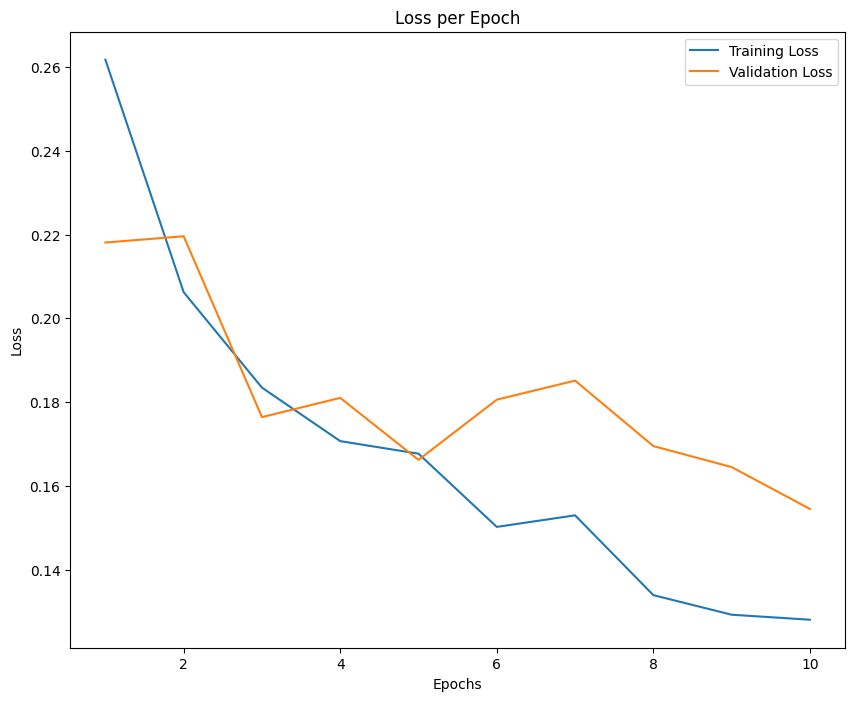

precision recall curve: 


NameError: name 'all_labels' is not defined

In [28]:
print("loss per epoch: ")
plot_losses(train_losses, val_losses)
print("precision recall curve: ")
plot_precision_recall_curve(all_labels, all_predictions)
print("confusion matrix: ")
plot_confusion_matrix(all_labels, all_predictions)

# Grid Search for Hyperparameter Optimisation

In [ ]:
#Hyperparameter Grid for tuning

hyperparameters = {
    'BATCH_SIZE': [16, 32, 64],
    'LR': [0.001, 0.01, 0.1],
}

In [ ]:
import itertools
import torch.optim as optim

# Function to run the training and validation process
def run_experiment(batch_size, learning_rate):
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    cv_loader = DataLoader(cv_set, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=batch_size*2, shuffle=False)

    model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, 2)  # Binary classification
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss().to(device)
    num_epochs = 10
    train_and_validate(model, train_loader, cv_loader, test_loader, criterion, optimizer, device, num_epochs, batch_size, learning_rate)

# Iterate over all combinations of hyperparameters
for batch_size, learning_rate in itertools.product(hyperparameters['BATCH_SIZE'], hyperparameters['LR']):
    print(f"Running experiment with BATCH_SIZE = {batch_size}, LR = {learning_rate}")
    run_experiment(batch_size, learning_rate)


Running experiment with BATCH_SIZE = 16, LR = 0.001


Epoch 1/10
Training Loss: 0.3160 | Training Accuracy: 87.06%
Validation Loss: 0.2820 | Validation Accuracy: 90.00% | Validation F1 Score: 0.8992


Epoch 2/10
Training Loss: 0.2547 | Training Accuracy: 89.95%
Validation Loss: 0.2299 | Validation Accuracy: 90.66% | Validation F1 Score: 0.9060


Epoch 3/10
Training Loss: 0.2334 | Training Accuracy: 90.77%
Validation Loss: 0.2271 | Validation Accuracy: 91.13% | Validation F1 Score: 0.9104


Epoch 4/10
Training Loss: 0.2144 | Training Accuracy: 91.42%
Validation Loss: 0.2152 | Validation Accuracy: 90.57% | Validation F1 Score: 0.9051


Epoch 5/10
Training Loss: 0.2048 | Training Accuracy: 91.80%
Validation Loss: 0.2207 | Validation Accuracy: 91.32% | Validation F1 Score: 0.9125


Epoch 6/10
Training Loss: 0.1992 | Training Accuracy: 92.04%
Validation Loss: 0.2136 | Validation Accuracy: 91.32% | Validation F1 Score: 0.9123


Epoch 7/10
Training Loss: 0.1910 | Training Accuracy: 92.46%
Validation Loss: 0.1920 | Validation Accuracy: 91.98% | Validation F1 Score: 0.9195


Epoch 8/10
Training Loss: 0.1836 | Training Accuracy: 92.82%
Validation Loss: 0.1792 | Validation Accuracy: 92.74% | Validation F1 Score: 0.9272


Epoch 9/10
Training Loss: 0.1829 | Training Accuracy: 92.49%
Validation Loss: 0.2109 | Validation Accuracy: 91.51% | Validation F1 Score: 0.9145


Epoch 10/10
Training Loss: 0.1733 | Training Accuracy: 93.01%
Validation Loss: 0.1956 | Validation Accuracy: 91.79% | Validation F1 Score: 0.9175
Model saved after training complete at /content/drive/MyDrive/AML_Coursework/models/efficientnetb0_bs16_lr0.0010.pth.
Final Evaluation Results:
Training - Loss: 0.1353, Accuracy: 94.41%, F1 Score: 0.9438
Validation - Loss: 0.1896, Accuracy: 92.45%, F1 Score: 0.9241
Running experiment with BATCH_SIZE = 16, LR = 0.01


Epoch 1/10
Training Loss: 0.5500 | Training Accuracy: 77.39%
Validation Loss: 0.4634 | Validation Accuracy: 82.74% | Validation F1 Score: 0.8246


Epoch 2/10
Training Loss: 0.3533 | Training Accuracy: 85.05%
Validation Loss: 0.3191 | Validation Accuracy: 86.04% | Validation F1 Score: 0.8604


Epoch 3/10
Training Loss: 0.3285 | Training Accuracy: 86.52%
Validation Loss: 0.4765 | Validation Accuracy: 79.81% | Validation F1 Score: 0.7980


Epoch 4/10
Training Loss: 0.3211 | Training Accuracy: 86.78%
Validation Loss: 0.3073 | Validation Accuracy: 86.89% | Validation F1 Score: 0.8688


Epoch 5/10
Training Loss: 0.3059 | Training Accuracy: 87.21%
Validation Loss: 0.3219 | Validation Accuracy: 87.83% | Validation F1 Score: 0.8775


Epoch 6/10
Training Loss: 0.3004 | Training Accuracy: 87.42%
Validation Loss: 0.3064 | Validation Accuracy: 87.45% | Validation F1 Score: 0.8741


Epoch 7/10
Training Loss: 0.2980 | Training Accuracy: 88.07%
Validation Loss: 0.4086 | Validation Accuracy: 81.51% | Validation F1 Score: 0.8071


Epoch 8/10
Training Loss: 0.2986 | Training Accuracy: 87.89%
Validation Loss: 0.3082 | Validation Accuracy: 88.40% | Validation F1 Score: 0.8829


Epoch 9/10
Training Loss: 0.2796 | Training Accuracy: 88.55%
Validation Loss: 0.3096 | Validation Accuracy: 88.68% | Validation F1 Score: 0.8867


Epoch 10/10
Training Loss: 0.2876 | Training Accuracy: 88.45%
Validation Loss: 0.2782 | Validation Accuracy: 87.36% | Validation F1 Score: 0.8735
Model saved after training complete at /content/drive/MyDrive/AML_Coursework/models/efficientnetb0_bs16_lr0.0100.pth.
Final Evaluation Results:
Training - Loss: 0.2528, Accuracy: 89.44%, F1 Score: 0.8943
Validation - Loss: 0.2741, Accuracy: 87.64%, F1 Score: 0.8763
Running experiment with BATCH_SIZE = 16, LR = 0.1


Epoch 1/10
Training Loss: 0.9030 | Training Accuracy: 72.75%
Validation Loss: 0.4892 | Validation Accuracy: 79.81% | Validation F1 Score: 0.7930


Epoch 2/10
Training Loss: 0.4588 | Training Accuracy: 80.25%
Validation Loss: 0.5058 | Validation Accuracy: 76.42% | Validation F1 Score: 0.7483


Epoch 3/10
Training Loss: 0.4450 | Training Accuracy: 81.51%
Validation Loss: 0.7569 | Validation Accuracy: 66.32% | Validation F1 Score: 0.6120


Epoch 4/10
Training Loss: 0.4678 | Training Accuracy: 80.87%
Validation Loss: 0.4197 | Validation Accuracy: 81.42% | Validation F1 Score: 0.8093


Epoch 5/10
Training Loss: 0.4090 | Training Accuracy: 82.80%
Validation Loss: 0.4895 | Validation Accuracy: 81.89% | Validation F1 Score: 0.8136


Epoch 6/10
Training Loss: 0.3756 | Training Accuracy: 83.71%
Validation Loss: 0.3991 | Validation Accuracy: 82.64% | Validation F1 Score: 0.8264


Epoch 7/10
Training Loss: 0.4021 | Training Accuracy: 83.36%
Validation Loss: 0.4326 | Validation Accuracy: 83.68% | Validation F1 Score: 0.8322


Epoch 8/10
Training Loss: 0.3836 | Training Accuracy: 84.05%
Validation Loss: 0.3231 | Validation Accuracy: 86.42% | Validation F1 Score: 0.8632


Epoch 9/10
Training Loss: 0.3580 | Training Accuracy: 84.96%
Validation Loss: 0.3972 | Validation Accuracy: 83.02% | Validation F1 Score: 0.8295


Epoch 10/10
Training Loss: 0.3588 | Training Accuracy: 84.74%
Validation Loss: 0.4747 | Validation Accuracy: 79.91% | Validation F1 Score: 0.7973
Model saved after training complete at /content/drive/MyDrive/AML_Coursework/models/efficientnetb0_bs16_lr0.1000.pth.
Final Evaluation Results:
Training - Loss: 0.4348, Accuracy: 80.50%, F1 Score: 0.8032
Validation - Loss: 0.4836, Accuracy: 80.00%, F1 Score: 0.7977
Running experiment with BATCH_SIZE = 32, LR = 0.001


Epoch 1/10
Training Loss: 0.2790 | Training Accuracy: 88.80%
Validation Loss: 0.2387 | Validation Accuracy: 91.51% | Validation F1 Score: 0.9148


Epoch 2/10
Training Loss: 0.2152 | Training Accuracy: 91.57%
Validation Loss: 0.2155 | Validation Accuracy: 92.08% | Validation F1 Score: 0.9204


Epoch 3/10
Training Loss: 0.2033 | Training Accuracy: 91.78%
Validation Loss: 0.1994 | Validation Accuracy: 92.08% | Validation F1 Score: 0.9200


Epoch 4/10
Training Loss: 0.2114 | Training Accuracy: 91.45%
Validation Loss: 0.1831 | Validation Accuracy: 92.45% | Validation F1 Score: 0.9241


Epoch 5/10
Training Loss: 0.1776 | Training Accuracy: 92.44%
Validation Loss: 0.1921 | Validation Accuracy: 92.26% | Validation F1 Score: 0.9221


Epoch 6/10
Training Loss: 0.1758 | Training Accuracy: 92.83%
Validation Loss: 0.1727 | Validation Accuracy: 93.21% | Validation F1 Score: 0.9319


Epoch 7/10
Training Loss: 0.1591 | Training Accuracy: 93.72%
Validation Loss: 0.1692 | Validation Accuracy: 93.02% | Validation F1 Score: 0.9300


Epoch 8/10
Training Loss: 0.1612 | Training Accuracy: 93.36%
Validation Loss: 0.1970 | Validation Accuracy: 93.11% | Validation F1 Score: 0.9309


Epoch 9/10
Training Loss: 0.1534 | Training Accuracy: 93.56%
Validation Loss: 0.1871 | Validation Accuracy: 92.45% | Validation F1 Score: 0.9242


Epoch 10/10
Training Loss: 0.1426 | Training Accuracy: 94.27%
Validation Loss: 0.1902 | Validation Accuracy: 92.92% | Validation F1 Score: 0.9290
Model saved after training complete at /content/drive/MyDrive/AML_Coursework/models/efficientnetb0_bs32_lr0.0010.pth.
Final Evaluation Results:
Training - Loss: 0.1232, Accuracy: 94.88%, F1 Score: 0.9487
Validation - Loss: 0.1912, Accuracy: 92.55%, F1 Score: 0.9252
Running experiment with BATCH_SIZE = 32, LR = 0.01


Epoch 1/10
Training Loss: 0.4964 | Training Accuracy: 78.62%
Validation Loss: 0.3263 | Validation Accuracy: 86.60% | Validation F1 Score: 0.8648


Epoch 2/10
Training Loss: 0.3228 | Training Accuracy: 86.22%
Validation Loss: 0.3181 | Validation Accuracy: 86.13% | Validation F1 Score: 0.8604


Epoch 3/10
Training Loss: 0.3039 | Training Accuracy: 87.42%
Validation Loss: 0.4047 | Validation Accuracy: 81.98% | Validation F1 Score: 0.8198


Epoch 4/10
Training Loss: 0.2964 | Training Accuracy: 87.71%
Validation Loss: 0.5042 | Validation Accuracy: 77.74% | Validation F1 Score: 0.7660


Epoch 5/10
Training Loss: 0.2982 | Training Accuracy: 87.48%
Validation Loss: 0.2888 | Validation Accuracy: 88.02% | Validation F1 Score: 0.8794


Epoch 6/10
Training Loss: 0.2811 | Training Accuracy: 88.40%
Validation Loss: 0.3126 | Validation Accuracy: 86.98% | Validation F1 Score: 0.8679


Epoch 7/10
Training Loss: 0.2751 | Training Accuracy: 88.84%
Validation Loss: 0.5239 | Validation Accuracy: 78.77% | Validation F1 Score: 0.7751


Epoch 8/10
Training Loss: 0.2762 | Training Accuracy: 88.61%
Validation Loss: 0.3639 | Validation Accuracy: 85.19% | Validation F1 Score: 0.8516


Epoch 9/10
Training Loss: 0.2699 | Training Accuracy: 89.23%
Validation Loss: 0.3048 | Validation Accuracy: 88.68% | Validation F1 Score: 0.8866


Epoch 10/10
Training Loss: 0.2653 | Training Accuracy: 89.32%
Validation Loss: 0.3317 | Validation Accuracy: 86.79% | Validation F1 Score: 0.8678
Model saved after training complete at /content/drive/MyDrive/AML_Coursework/models/efficientnetb0_bs32_lr0.0100.pth.
Final Evaluation Results:
Training - Loss: 0.2873, Accuracy: 88.07%, F1 Score: 0.8807
Validation - Loss: 0.3141, Accuracy: 86.51%, F1 Score: 0.8649
Running experiment with BATCH_SIZE = 32, LR = 0.1


Epoch 1/10
Training Loss: 1.5870 | Training Accuracy: 64.91%
Validation Loss: 0.4681 | Validation Accuracy: 76.79% | Validation F1 Score: 0.7633


Epoch 2/10
Training Loss: 0.4841 | Training Accuracy: 78.83%
Validation Loss: 0.4259 | Validation Accuracy: 78.68% | Validation F1 Score: 0.7862


Epoch: [3][120/266] Loss 0.2653 (0.4463) Acc 87.50 (79.60):  47%|████▋     | 126/266 [01:00<01:06,  2.09it/s]